In [61]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import os

In [62]:
DATASET_PATH = "./Sandal/"

images = []

for idx, filename in enumerate(os.listdir(DATASET_PATH)):
    img = tf.keras.preprocessing.image.load_img(os.path.join(DATASET_PATH, filename), target_size=(102,136))
    img = tf.keras.preprocessing.image.img_to_array(img)
    images.append(img)

    if idx > 2000:
        break

In [63]:
# Preprocess Images
images = np.asarray(images).astype(np.float32) / 255.

x_train = images[:-10]
x_test = images[-10:]

In [64]:
# Define hyperparameters
BATCH_SIZE = 20
IMAGE_ORIGINAL_SHAPE = x_train.shape[1:]
IMAGE_SIZE = IMAGE_ORIGINAL_SHAPE[0] * IMAGE_ORIGINAL_SHAPE[1] * IMAGE_ORIGINAL_SHAPE[2]
HIDDEN_DIM = 512
LATENT_DIM = 32
MAX_EPOCHS = 10
LEARNING_RATE = 0.0001


In [65]:
# Model Creation
class VAE(tf.keras.Model):
    def __init__(self, dim, **kwargs):
        super(VAE, self).__init__(**kwargs)

        h_dim = dim[0]
        z_dim = dim[1]

        self.fc1 = tf.keras.layers.Dense(h_dim, activation = tf.nn.relu)
        self.fc2 = tf.keras.layers.Dense(z_dim)
        self.fc3 = tf.keras.layers.Dense(z_dim)
        self.fc4 = tf.keras.layers.Dense(h_dim)
        self.fc5 = tf.keras.layers.Dense(IMAGE_SIZE)

        self.encoder_batch_norm = tf.keras.layers.BatchNormalization()
        self.decoder_batch_norm = tf.keras.layers.BatchNormalization()

    def encode(self, x):
        x = self.encoder_batch_norm(x)
        h = self.fc1(x)
        return self.fc2(h), self.fc3(h)

    def decode_logits(self, z):
        h = self.fc4(z)
        h = self.fc5(h)
        return self.decoder_batch_norm(h)

    def decode(self, z):
        return tf.nn.sigmoid(self.decode_logits(z))

    def reparameterize(self, mu, log_var):
        std = tf.exp(log_var * 0.5)
        eps = tf.random.normal(std.shape)
        return mu + eps * std

    def call(self, input, training = None, mask = None):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        x_recon_logits = self.decode_logits(z)
        
        return x_recon_logits, mu, log_var

In [66]:
# Model Creation
model = VAE([HIDDEN_DIM, LATENT_DIM])
model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE))
print(model.summary())

Model: "vae_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            multiple                  21307904  
                                                                 
 dense_30 (Dense)            multiple                  16416     
                                                                 
 dense_31 (Dense)            multiple                  16416     
                                                                 
 dense_32 (Dense)            multiple                  16896     
                                                                 
 dense_33 (Dense)            multiple                  21349008  
                                                                 
 batch_normalization_12 (Bat  multiple                 166464    
 chNormalization)                                                
                                                             

In [67]:
optimizers = tf.keras.optimizers.Adam(LEARNING_RATE)

dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(BATCH_SIZE * 5).batch(BATCH_SIZE)

In [70]:
loss_history = []
kl_div_history = []

num_batches = x_train.shape[0]

for epoch in range(MAX_EPOCHS):
    for x in dataset:
        x = tf.reshape(x, [-1, IMAGE_SIZE])
        
        with tf.GradientTape() as tape:
            x_reconstruction_logits, mu, log_var = model(x)
            
            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(
                labels = x,
                logits = x_reconstruction_logits
            )
            
            reconstruction_loss = tf.reduce_sum(reconstruction_loss) / BATCH_SIZE
            
            kl_div = -0.5 * tf.reduce_sum(1. + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
            kl_div = tf.reduce_mean(kl_div)

            loss = tf.reduce_mean(reconstruction_loss + kl_div)
            
        gradients = tape.gradient(loss, model.trainable_variables)
    
        for g in gradients:
            tf.clip_by_norm(g, 15)
            
        optimizers.apply_gradients(zip(gradients, model.trainable_variables))
    
    loss_history.append(reconstruction_loss)
    kl_div_history.append(kl_div)
    
    print(f"Epoch: [{epoch}/{MAX_EPOCHS}] | Recon Loss: {float(reconstruction_loss):.2f} | KL Div: {kl_div}:.2f | Loss: {float(loss):.2f}")       
        

Epoch: [0/10] | Recon Loss: 7393.94 | KL Div: 238.1445770263672:.2f | Loss: 7632.09
Epoch: [1/10] | Recon Loss: 7496.40 | KL Div: 229.5074920654297:.2f | Loss: 7725.90
Epoch: [2/10] | Recon Loss: 7153.68 | KL Div: 194.73460388183594:.2f | Loss: 7348.41
Epoch: [3/10] | Recon Loss: 7931.76 | KL Div: 184.75634765625:.2f | Loss: 8116.51
Epoch: [4/10] | Recon Loss: 6766.11 | KL Div: 235.1227264404297:.2f | Loss: 7001.23
Epoch: [5/10] | Recon Loss: 7938.01 | KL Div: 164.96083068847656:.2f | Loss: 8102.97
Epoch: [6/10] | Recon Loss: 7238.20 | KL Div: 191.98272705078125:.2f | Loss: 7430.18
Epoch: [7/10] | Recon Loss: 7108.15 | KL Div: 181.8265380859375:.2f | Loss: 7289.97
Epoch: [8/10] | Recon Loss: 6979.09 | KL Div: 207.50927734375:.2f | Loss: 7186.60
Epoch: [9/10] | Recon Loss: 7699.24 | KL Div: 177.8842315673828:.2f | Loss: 7877.12


Text(0, 0.5, 'KL Div')

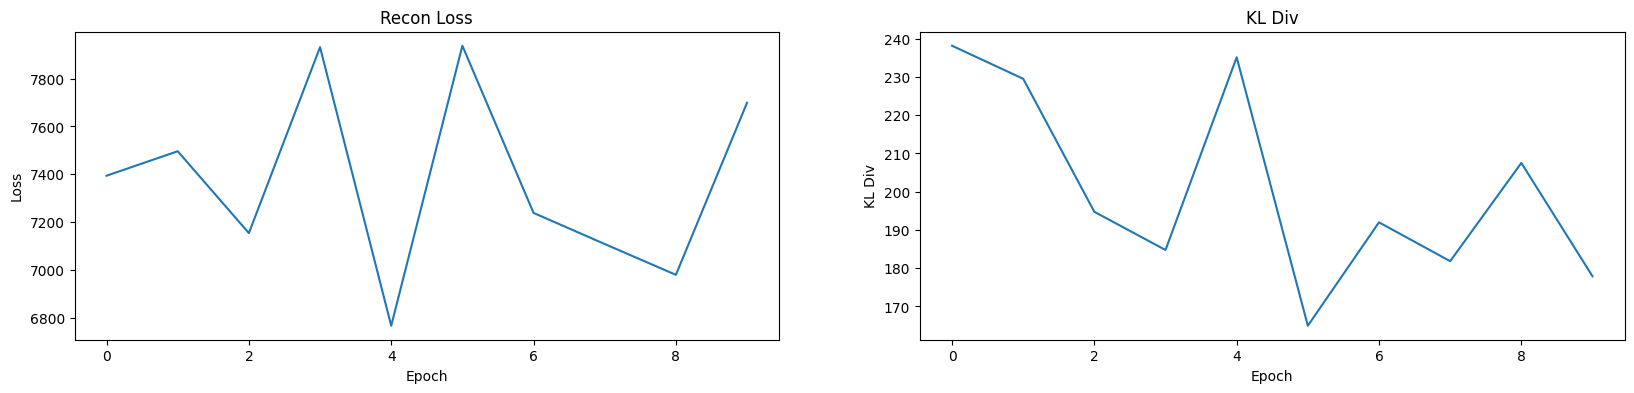

In [72]:
plt.figure(figsize=(20,4))
plt.subplot(1, 2, 1)
plt.title("Recon Loss")
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.title("KL Div")
plt.plot(kl_div_history)
plt.xlabel("Epoch")
plt.ylabel("KL Div")

In [71]:
def get_out_from_z(z):
    out = model.decode(z)
    out = tf.reshape(out, (-1, IMAGE_ORIGINAL_SHAPE[0], IMAGE_ORIGINAL_SHAPE[1], IMAGE_ORIGINAL_SHAPE[2]))
    # out = out.astype(np.uint8)
    return out

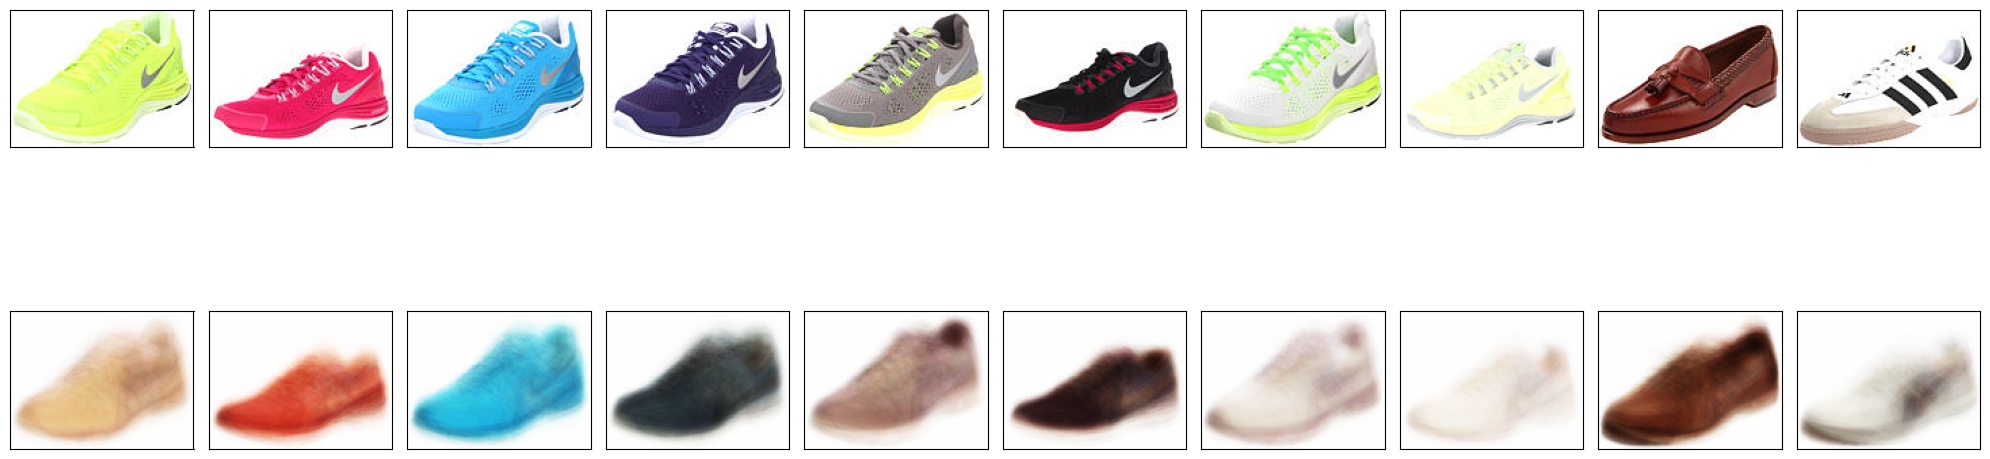

In [73]:
mu, log_var = model.encode(x_test.reshape(-1, IMAGE_SIZE))
z = model.reparameterize(mu, log_var)
out = get_out_from_z(z)

number = 10
plt.figure(figsize = (20,8))
for idx in range(number):
    ax = plt.subplot(2, number, idx+1)
    plt.imshow(x_test[idx].reshape(IMAGE_ORIGINAL_SHAPE), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for idx in range(number):
    ax = plt.subplot(2, number, number+idx+1)
    plt.imshow(out[idx], cmap ='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

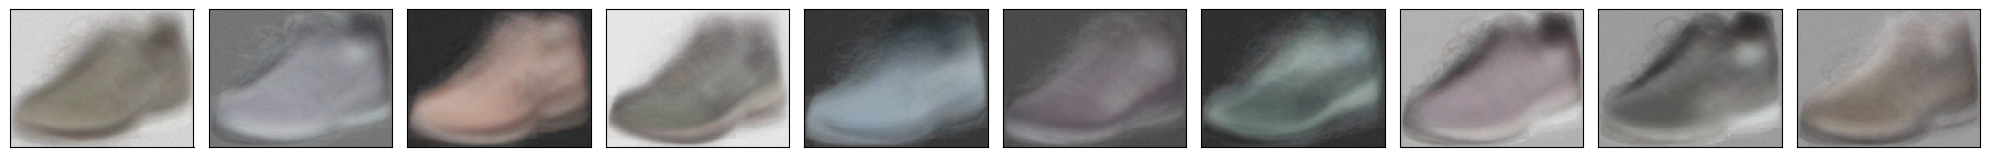

In [74]:
z = tf.random.normal([BATCH_SIZE, LATENT_DIM])

out = get_out_from_z(z)

number = 10
plt.figure(figsize=(20,4))
for idx in range(number):
    ax = plt.subplot(2, number, idx+1)
    plt.imshow(out[idx], cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()
